In [ ]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [ ]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    if i >= 8:
        break

In [ ]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

In [ ]:
%matplotlib inline

plt.close('all')

for i, r in enumerate(records):
    for j, tr in enumerate(r.trials):
        pattern = None
        if (i, j) == (6, 11):
            # hardcode pattern for (6, 11)
            pattern=(0, -1, 0, 1, 0, -1, 0, 1, 0)
            
        try:
            tr.event._identify_steer_slice(pattern=pattern)
            print('{}-{}: start time: {}'.format(i, j, tr.event.steer_slice.start))
        except TypeError as e:
            if e.args == ('Incorrect EventType',):
                pass
            else:
                raise e
        #else:
        #    tr.event.plot_steer_identification(figsize=(12, 24))
        #    plt.show()

In [ ]:
review_set = {
    (2, 9),
    (3, 7)
}
colors = sns.color_palette('tab10', 10)

for i, r in enumerate(records):
    for j, tr in enumerate(r.trials):
        if (i, j) not in review_set:
            continue
            
        print('steer identification for rider {} trial {}'.format(i, j))
        evt = tr.event
        if evt.si is not None:
            evt.plot_steer_identification(figsize=(12, 24))
        
            z0 = evt.z.min()
            z1 = evt.z.max()
            t0 = evt.lidar.time[0]
            t1 = evt.lidar.time[-1]
    
            tstart = evt.bicycle.time[evt.steer_slice][0]
            tstop = evt.lidar.time[evt.lidar.frame_index(tstart) + 1][0]
            zstart, zstop = np.interp([tstart, tstop], [t0, t1], [z0, z1])
            index = (evt.z.data < zstart) | (evt.z.data > zstop)
            
            x = evt.x.copy()
            y = evt.y.copy()
            
            fig, ax = plt.subplots(figsize=(12, 12))
            x.mask = evt.bb_mask | ~evt.stationary_mask | index
            y.mask = evt.bb_mask | ~evt.stationary_mask | index
            ax.scatter(x, y, color=colors[2], alpha=0.5, label='stationary')
            x.mask = evt.bb_mask | evt.stationary_mask | index
            y.mask = evt.bb_mask | evt.stationary_mask | index
            ax.scatter(x, y, color=colors[0], alpha=0.5, label='cyclist')
            ax.legend()
            ax.set_title('classified lidar points for [{:0.3f}, {:0.3f}]'.format(tstart, tstop))
            
            plt.show()

In [41]:
from antlia import filter as ff
import pandas as pd

d = {
    'rider id': [],
    'trial id': [],
    'start index': [],
    'starting velocity': [],
    'distance-to-collision': [],
    'time-to-collision': [],
}

for i, r in enumerate(records):
    for j, tr in enumerate(r.trials):
        evt = tr.event
        if evt.steer_slice is not None:
            t0 = evt.bicycle.time[evt.steer_slice.start]
            dtc = evt.calculate_dtc(t0)
            k = evt.steer_slice.start
            filtered_v = ff.moving_average(evt.bicycle.speed,
                                           window_size=55,
                                           sigma=55/2)
            v0 = filtered_v[k]
            ttc = dtc/v0
            
            d['rider id'].append(i)
            d['trial id'].append(j)
            d['start index'].append(k)
            d['starting velocity'].append(v0)
            d['distance-to-collision'].append(evt.calculate_dtc(t0))
            d['time-to-collision'].append(ttc)
            
            #k = evt.lidar.frame_index(t0)
            #fig, ax = evt._plot_closest_pair(k, figsize=(12, 12))
            #plt.show()
            
df = pd.DataFrame(data=d)
df

,distance-to-collision,rider id,start index,starting velocity,time-to-collision,trial id
0,10.470495,0,733,3.827718,2.735440,3
1,4.693497,0,529,6.606079,0.710482,4
2,5.666304,0,675,4.942111,1.146535,5
3,9.369900,0,547,4.978479,1.882081,9
4,7.698607,0,485,6.449297,1.193713,10
5,5.803123,0,920,3.618118,1.603907,11
6,7.120113,0,430,6.254745,1.138354,15
7,8.513010,0,584,4.946657,1.720962,16
8,5.451713,0,910,3.640485,1.497524,17
9,4.923379,1,992,3.499407,1.406918,0


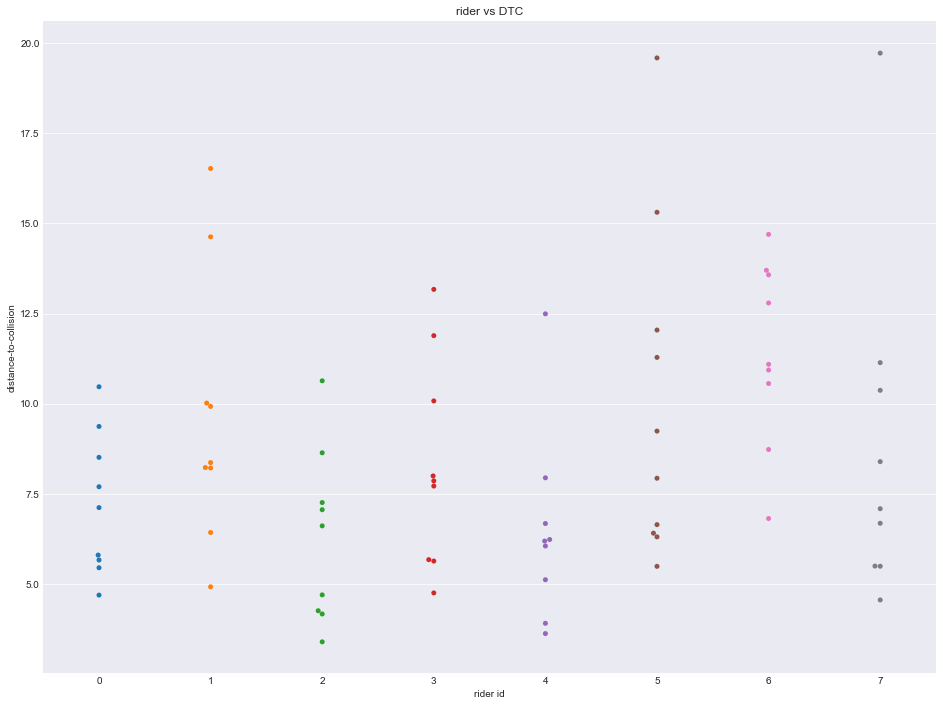

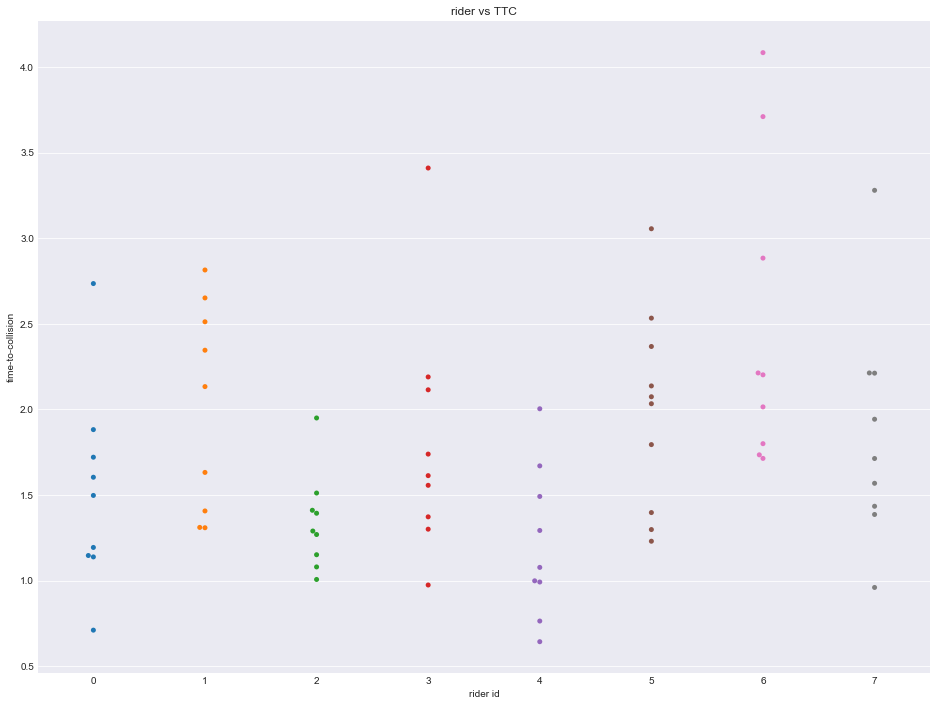

In [42]:
plt.close('all')

fig, ax = plt.subplots(figsize=(16, 12))
sns.swarmplot(x='rider id', y='distance-to-collision', data=df, ax=ax)
ax.set_title('rider vs DTC')

fig, ax = plt.subplots(figsize=(16, 12))
sns.swarmplot(x='rider id', y='time-to-collision', data=df, ax=ax)
ax.set_title('rider vs TTC')

plt.show()

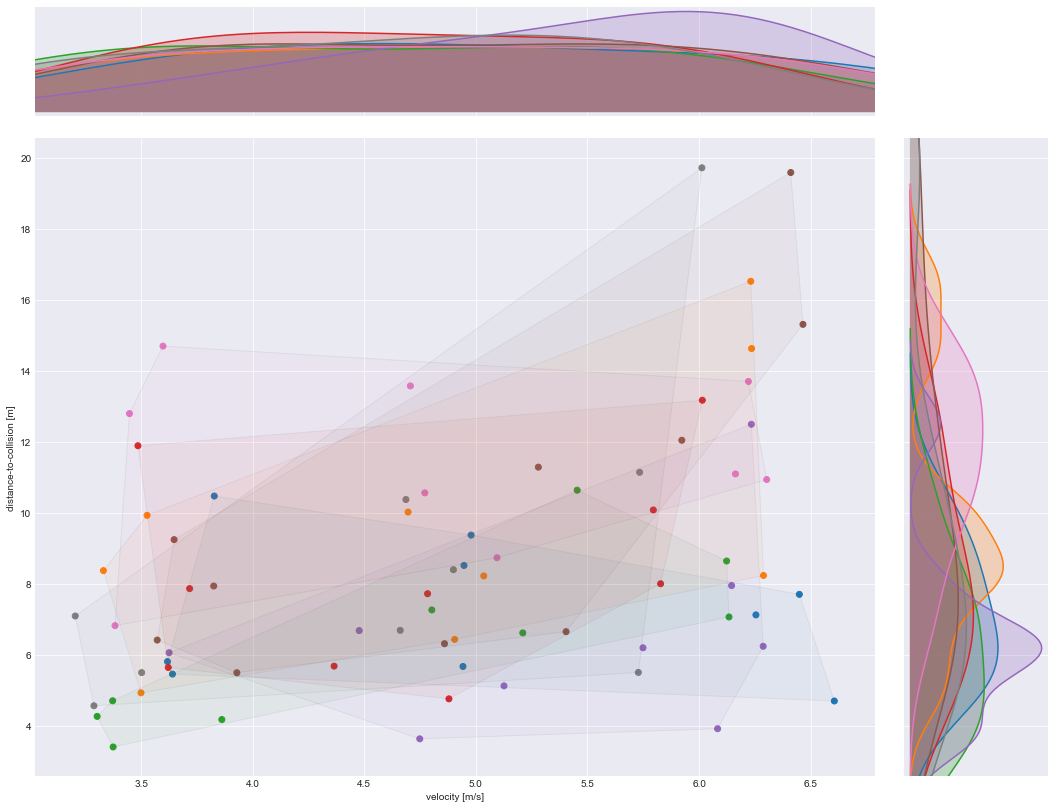

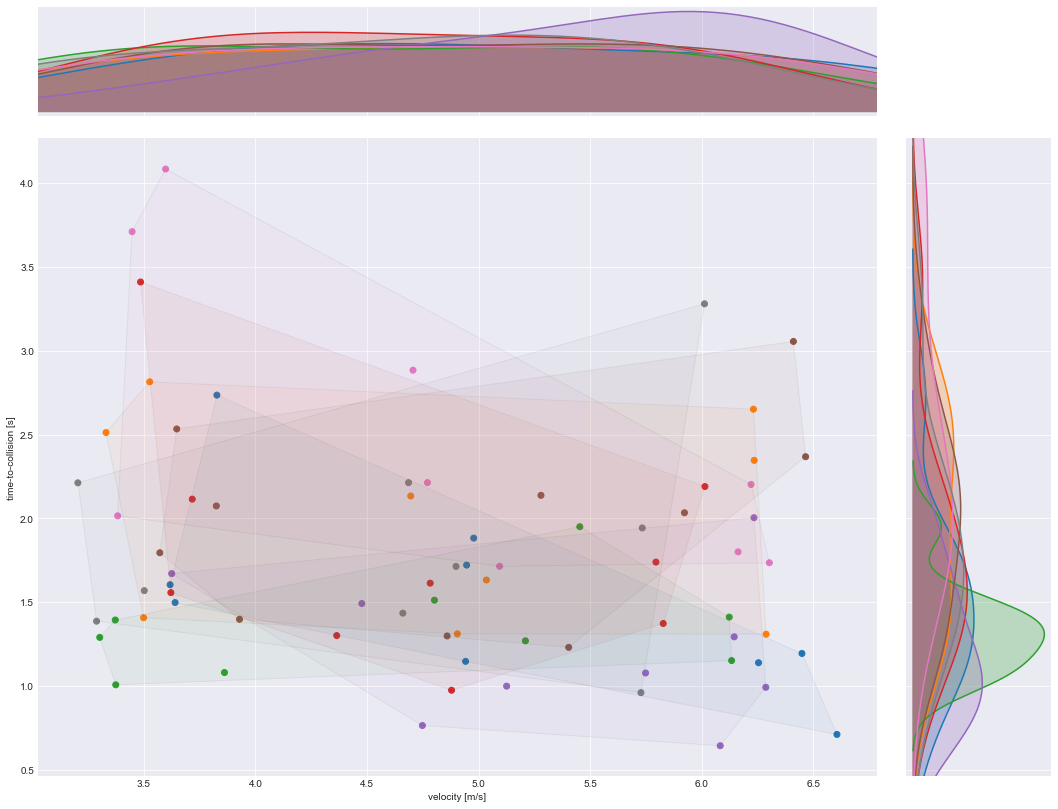

In [44]:
from antlia.plotdf import plotjoint

colors = sns.color_palette('tab10', 10)

plt.close('all')
g = plotjoint('starting velocity', 'distance-to-collision', df,
              kde_key=('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'distance-to-collision [m]')

g = plotjoint('starting velocity', 'time-to-collision', df,
              kde_key=('rider id', colors))
g.fig.set_size_inches(DEFAULT_FIGSIZE)
g.set_axis_labels('velocity [m/s]', 'time-to-collision [s]')
plt.show()

In [45]:
df.to_pickle('trial2_steering_ttc.p.gz')